### 第1步：导入库

In [44]:
import pandas as pd #做数据分析
import numpy as np #数据处理
import matplotlib.pyplot as plt #绘图
import os #读取多个文件数据
from sklearn.preprocessing import MinMaxScaler #归一化
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.optimizers import SGD

### 第2步：加载历史数据文件

In [45]:
inputdir=r'C:\Users\wydx\长短期神经网络 lstm\data1'
#dataset=pd.DataFrame(columns=[1,2,3,4,5,6,7,8,9])
dataset=pd.DataFrame()
for parents, dirnames, filenames in os.walk(inputdir):
    for filename in filenames:
        df=pd.read_excel(os.path.join(parents,filename))
        dataset=dataset.append(df,ignore_index=True)

In [46]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9
0,0.038002,0.036994,0.439709,0.146683,0.001385,0.999541,0.999097,1.001269,0.996959,0.192059
1,0.037063,0.037832,0.439553,0.148619,0.001015,0.999560,0.996968,0.998118,1.000213,0.192584
2,0.036576,0.039160,0.440214,0.147065,-0.001096,0.999570,0.998475,0.997347,1.000505,0.192514
3,0.036031,0.038348,0.438896,0.145748,0.000130,0.999160,0.997963,0.999083,0.999222,0.194257
4,0.035790,0.035858,0.437862,0.147233,-0.000600,0.999606,0.995651,0.997604,0.998832,0.192781


In [47]:
dataset.shape#（291个数据，包含10个字段）

(873, 10)

In [48]:
# 检查数据是否有缺失值
train_set = dataset[:660].iloc[:,:].values # 训练集，获取所有行所有列的数据
test_set = dataset[661:].iloc[:,:].values # 测试集，获取所有行所有列的数据

In [49]:
train_set.shape

(660, 10)

In [50]:
test_set.shape

(212, 10)

### 第3步：定义显示函数

In [51]:
def plot_predictions(test_result, predict_restult):
    """
    test_result: 真实值
    predict_result: 预测值
    """
    plt.plot(test_result, color='red', label='predict')
    plt.plot(predict_restult, color='blue', label="true")
    plt.title("nosie")
    plt.xlabel("times")
    plt.ylabel("value")
    plt.legend() # 给图加上图例
    plt.show()

### 第4步：绘制训练集和测试集的数据

In [52]:
#正则化：将每一维的特征映射到指定的区间：【0，1】
sc = MinMaxScaler(feature_range=[0, 1])
train_set_scaled = sc.fit_transform(train_set)
test_set_scaled = sc.fit_transform(test_set)

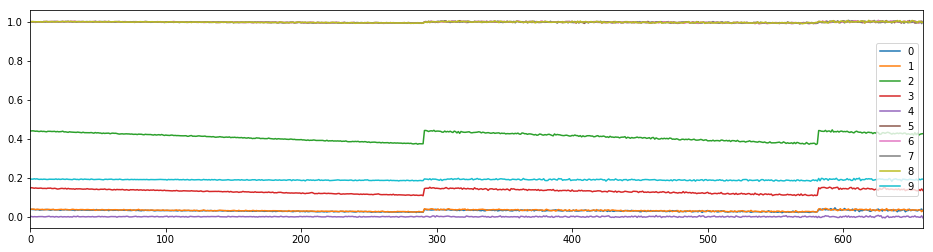

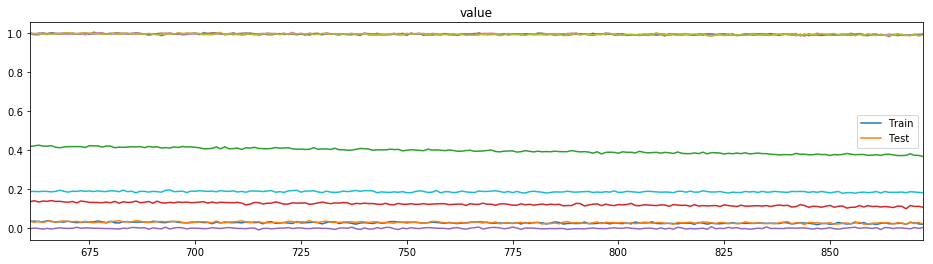

In [53]:
dataset[:][:660].plot(figsize=(16, 4), legend=True)
dataset[:][661:].plot(figsize=(16, 4), legend=True)
plt.title("value")
plt.legend(['Train', 'Test'])
plt.show()

In [54]:
# 创建序列数据集（训练和测试）
# 60个时间步为一个样本，1个输出。这里的思路类似于滑动窗口
X_train = []
y_train = []
time_step=20
for i in range(time_step, 660):
    X_train.append(train_set_scaled[i-time_step:i,:]) #0-59,60个数
    y_train.append(train_set_scaled[i,:])#60,第60个数是标签

X_train, y_train = np.array(X_train), np.array(y_train) # numpy类型变换

In [55]:
 X_train.shape #600个样本，维度是60*10

(640, 20, 10)

In [56]:
X_train[0]

array([[ 0.70134385,  0.72100315,  0.92786838,  0.89466064,  0.58545284,
         0.65369388,  0.57898611,  0.68024332,  0.45325838,  0.64596846],
       [ 0.66395517,  0.7636901 ,  0.92578801,  0.93856332,  0.55759943,
         0.65482881,  0.46656796,  0.4958411 ,  0.63519694,  0.67737164],
       [ 0.64455848,  0.83136268,  0.9345927 ,  0.90332086,  0.39858043,
         0.65541298,  0.54612656,  0.45069843,  0.6515067 ,  0.67318734],
       [ 0.62284521,  0.78998435,  0.91705041,  0.87345811,  0.49094546,
         0.63116234,  0.51908719,  0.55231872,  0.5797826 ,  0.77746872],
       [ 0.61326388,  0.66311328,  0.9033011 ,  0.90713719,  0.43588552,
         0.65753004,  0.39707315,  0.4657233 ,  0.55801221,  0.68917208],
       [ 0.615626  ,  0.79054025,  0.91643708,  0.87920606,  0.42344282,
         0.5991382 ,  0.57402273,  0.50055055,  0.58322875,  0.77088026],
       [ 0.64390378,  0.72228697,  0.89060864,  0.86916563,  0.50371093,
         0.63776116,  0.52887989,  0.57395127

In [57]:
# LSTM的输入：(samples, sequence_length, features) 
# reshape: 训练集(2709,60)  ---> (2709, 60, 1)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 10)) 

In [58]:
X_train.shape

(640, 20, 10)

### 搭建LSTM模型，进行训练和预测

In [59]:
model = Sequential()
# LSTM 第一层
model.add(LSTM(512, return_sequences=True, input_shape=(X_train.shape[1], 10)))
model.add(Dropout(0.7))

# LSTM 第二层
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.7))

# LSTM 第三层
model.add(LSTM(512))
model.add(Dropout(0.7))

# Dense层
model.add(Dense(units=10))

In [60]:
# 模型编译
model.compile(optimizer='rmsprop', loss='mse')

# 模型训练
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
640/640 [==============================] - 22s 34ms/step - loss: 0.1416
Epoch 2/100
640/640 [==============================] - 19s 30ms/step - loss: 0.0539
Epoch 3/100
640/640 [==============================] - 19s 30ms/step - loss: 0.0417
Epoch 4/100
640/640 [==============================] - 19s 30ms/step - loss: 0.0361
Epoch 5/100
640/640 [==============================] - 19s 30ms/step - loss: 0.0379
Epoch 6/100
640/640 [==============================] - 18s 29ms/step - loss: 0.0266
Epoch 7/100
640/640 [==============================] - 19s 29ms/step - loss: 0.0275
Epoch 8/100
640/640 [==============================] - 18s 28ms/step - loss: 0.0262
Epoch 9/100
640/640 [==============================] - 17s 26ms/step - loss: 0.0246
Epoch 10/100
640/640 [==============================] - 16s 25ms/step - loss: 0.0244
Epoch 11/100
640/640 [==============================] - 17s 27ms/step - loss: 0.0203
Epoch 12/100
640/640 [==============================] - 17s 26ms/step - lo

640/640 [==============================] - 16s 25ms/step - loss: 0.0125
Epoch 98/100
640/640 [==============================] - 16s 25ms/step - loss: 0.0120
Epoch 99/100
640/640 [==============================] - 16s 25ms/step - loss: 0.0123
Epoch 100/100
640/640 [==============================] - 16s 25ms/step - loss: 0.0121


In [61]:
# 准备测试集X_test,进行预测
X_test = []
for i in range(time_step,212):
    X_test.append(test_set_scaled[i-time_step:i,:])
    
X_test = np.array(X_test) # numpy 类型转换

X_test.shape

(192, 20, 10)

### 构建测试集X_test, 进行估价预测

In [62]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 10))

In [63]:
X_test.shape

(192, 20, 10)

In [64]:
predict_test = model.predict(X_test) # 预测

In [65]:
predict_test.shape

(192, 10)

In [66]:
predict_test[0]

array([ 0.53300655,  0.66948879,  0.85162252,  0.83312881,  0.44847018,
        0.66860616,  0.62370282,  0.59998852,  0.62436634,  0.61507595], dtype=float32)

In [67]:
predict_test[100]

array([ 0.34237587,  0.40760928,  0.48875839,  0.47450542,  0.45789024,
        0.48811221,  0.46235967,  0.41602135,  0.45349395,  0.44245708], dtype=float32)

In [68]:
predict=[]
for i in range(0,192):
    predict.append(predict_test[i,:])
predict_test=np.array(predict_test)

In [69]:
# 绘制测试结果和预测结果
true = []
for i in range(0,192):
    true.append(X_test[i,0,:])
true = np.array(true) # numpy 类型转换

true.shape

(192, 10)

In [70]:
true[:,0].shape

(192,)

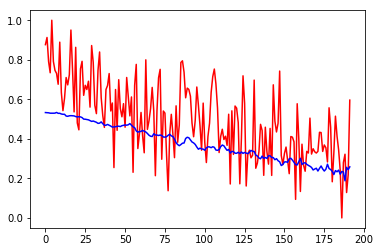

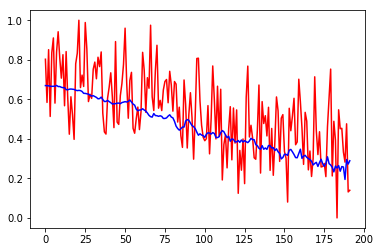

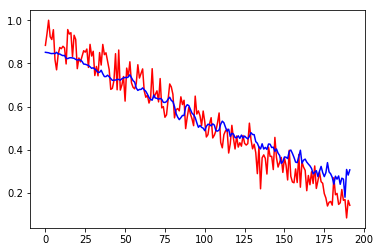

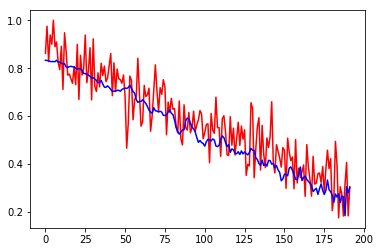

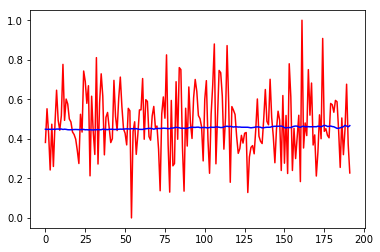

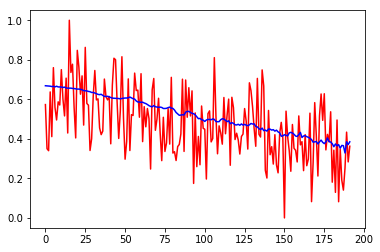

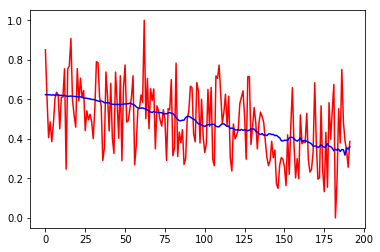

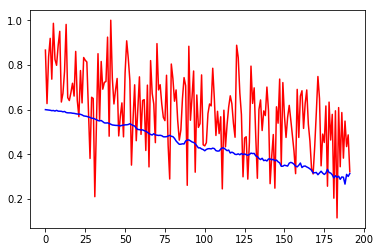

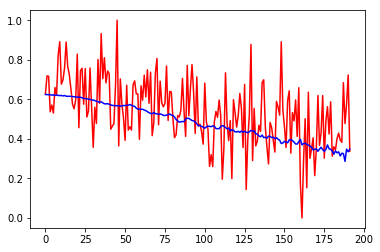

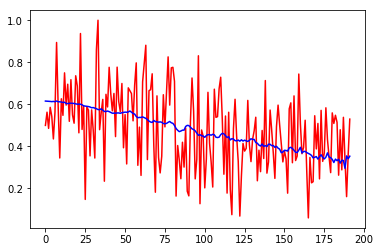

In [71]:
for i in range(0,10):
    plt.plot(true[:,i],c='red')
    plt.plot(predict_test[:,i],c='blue')
    plt.show()

In [205]:
abs(true[0][0]-predict_test[0][0])

0.37173350327705157

In [206]:
loss=np.array([0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00],)
for i in range(0,152):
    for j in range(0,10):
        loss[j]+=abs(predict_test[i][j]-true[i][j])/abs(true[i][j])
loss/=152
loss

D:\Anaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


array([ 0.30471146,  0.23705956,  0.08870404,  0.13889185,         inf,
               inf,  0.29371329,  0.29421884,  0.21815848,  0.4227771 ])